In [1]:
'''
38-Cloud: Cloud Segmentation in Satellite Images
'''

'\n38-Cloud: Cloud Segmentation in Satellite Images\n'

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [3]:
class CustomCloudDataset(Dataset):
    def __init__(self, red_dir, green_dir, blue_dir, nir_dir, gt_dir, transform=None):
        self.red_files = list(Path(red_dir).glob('*.tif'))
        self.green_dir = green_dir
        self.blue_dir = blue_dir
        self.nir_dir = nir_dir
        self.gt_dir = gt_dir
        self.transform = transform

    def __len__(self):
        return len(self.red_files)

    def __getitem__(self, idx):
        file_name = self.red_files[idx].name

        red = Image.open(self.red_files[idx])
        green = Image.open(Path(self.green_dir) / file_name.replace('red', 'green'))
        blue = Image.open(Path(self.blue_dir) / file_name.replace('red', 'blue'))
        nir = Image.open(Path(self.nir_dir) / file_name.replace('red', 'nir'))
        gt = Image.open(Path(self.gt_dir) / file_name.replace('red', 'gt'))

        image = np.stack([np.array(red), np.array(green), np.array(blue), np.array(nir)], axis=2).astype(np.float32)
        mask = np.array(gt).astype(np.uint8)
        mask = np.where(mask == 255, 1, 0).astype(np.uint8)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        image = torch.from_numpy(image).float().permute(2, 0, 1)
        mask = torch.from_numpy(mask).long()

        return image, mask

    def open_as_array(self, idx, include_nir=True):
        file_name = self.red_files[idx].name

        red = np.array(Image.open(self.red_files[idx]))
        green = np.array(Image.open(Path(self.green_dir) / file_name.replace('red', 'green')))
        blue = np.array(Image.open(Path(self.blue_dir) / file_name.replace('red', 'blue')))

        if include_nir:
            nir = np.array(Image.open(Path(self.nir_dir) / file_name.replace('red', 'nir')))
            image = np.stack([red, green, blue, nir], axis=2)
        else:
            image = np.stack([red, green, blue], axis=2)

        # Normalize the image
        max_val = np.iinfo(image.dtype).max
        image = image.astype(np.float32) / max_val

        return image
    
    def open_mask(self, idx):
        file_name = self.red_files[idx].name
        mask = np.array(Image.open(Path(self.gt_dir) / file_name.replace('red', 'gt')))
        mask = np.where(mask == 255, 1, 0)
        return mask

In [4]:
path = "./38-Cloud_training/"
red_dir = path + "train_red"
green_dir = path + "train_green"
blue_dir = path + "train_blue"
nir_dir = path + "train_nir"
gt_dir = path + "train_gt"

dataset = CustomCloudDataset(red_dir, green_dir, blue_dir, nir_dir, gt_dir)
print(len(dataset))

8400


In [5]:
x, y = dataset[1200]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

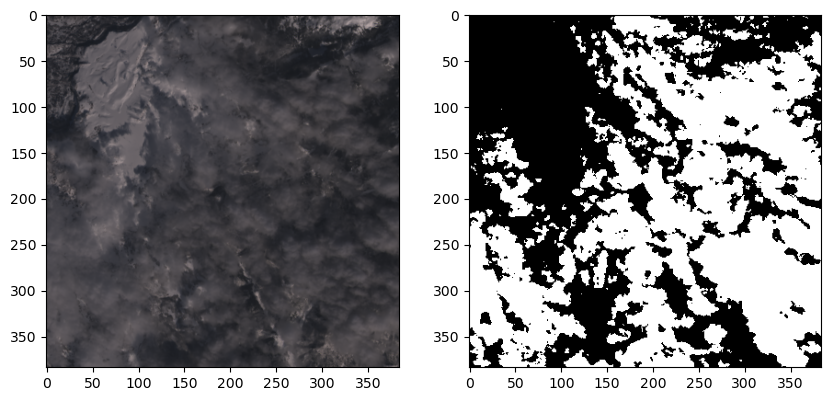

In [6]:
'''
The ideas for the drawing portion were inspired by this article: 
https://www.kaggle.com/code/cordmaur/38-cloud-data-preparation?scriptVersionId=31357028
'''

fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].imshow(dataset.open_as_array(1000, include_nir=False))
ax[1].imshow(dataset.open_mask(1000), cmap='gray')

plt.show()

In [7]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
#train_size = int(0.1 * total_size)
#val_size = int(0.01 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

print(f"Using device: {device}")


Using device: cuda


In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, middle_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(middle_channels + out_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Downsampling
        self.down_conv1 = ConvBlock(in_channels, 64)
        self.down_conv2 = ConvBlock(64, 128)
        self.down_conv3 = ConvBlock(128, 256)
        self.down_conv4 = ConvBlock(256, 512)

        # Upsampling
        self.up_block1 = UpBlock(512, 256, 256)  # Input 512, middle 256, concatenate with 256 from skip connection
        self.up_block2 = UpBlock(256, 128, 128)  # Input 256, middle 128, concatenate with 128 from skip connection
        self.up_block3 = UpBlock(128, 64, 64)    # Input 128, middle 64, concatenate with 64 from skip connection

        # Final layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Downsampling
        x1 = self.down_conv1(x)
        x2 = self.down_conv2(F.max_pool2d(x1, 2))
        x3 = self.down_conv3(F.max_pool2d(x2, 2))
        x4 = self.down_conv4(F.max_pool2d(x3, 2))

        # Upsampling
        x = self.up_block1(x4, x3)
        x = self.up_block2(x, x2)
        x = self.up_block3(x, x1)

        # Final layer
        out = self.final_conv(x)
        return out

In [9]:
n_channels = 4 # Number of channels in the input image (e.g., RGB+NIR)

# The number of output channels is 2 for binary classification
model = UNet(n_channels, 2)

loss_fn = nn.CrossEntropyLoss()

In [10]:
print(model)

UNet(
  (down_conv1): ConvBlock(
    (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down_conv2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down_conv3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [11]:
def train_model(model, train_dl, valid_dl, loss_fn, optimizer, epochs, n_classes):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        train_loss, train_corrects, train_pixels = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Debugging purpose
            if torch.any(labels >= n_classes):
                print(f"Invalid label detected. Labels should be less than {n_classes}.")

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()
            
            # Convert the model's output to predicted classes
            preds = outputs.argmax(dim=1)
            
            # Update training metrics
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)
            train_pixels += torch.numel(labels)
        
        # Calculate and print training loss and accuracy
        train_epoch_loss = train_loss / len(train_dl.dataset)
        train_epoch_acc = train_corrects.double() / train_pixels
        print(f'Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')

        # Validation phase
        model.eval()
        valid_loss, valid_corrects, valid_pixels = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in valid_dl:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                preds = outputs.argmax(dim=1)
                valid_loss += loss.item() * inputs.size(0)
                valid_corrects += torch.sum(preds == labels.data)
                valid_pixels += torch.numel(labels)

        valid_epoch_loss = valid_loss / len(valid_dl.dataset)
        valid_epoch_acc = valid_corrects.double() / valid_pixels
        print(f'Valid Loss: {valid_epoch_loss:.4f} Acc: {valid_epoch_acc:.4f}')

    print('Training complete')

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
epochs = 30  # Set the number of epochs
n_classes = 2
train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, n_classes)

Epoch 0/29
----------
Train Loss: 0.3824 Acc: 0.8126
Valid Loss: 0.3080 Acc: 0.8727
Epoch 1/29
----------
Train Loss: 0.3489 Acc: 0.8355
Valid Loss: 0.2606 Acc: 0.9022
Epoch 2/29
----------
Train Loss: 0.3234 Acc: 0.8496
Valid Loss: 0.2405 Acc: 0.8951
Epoch 3/29
----------
Train Loss: 0.2935 Acc: 0.8719
Valid Loss: 0.1792 Acc: 0.9333
Epoch 4/29
----------
Train Loss: 0.2775 Acc: 0.8835
Valid Loss: 0.1680 Acc: 0.9405
Epoch 5/29
----------


KeyboardInterrupt: 